In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import ShuffleSplit,GridSearchCV,train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# from imblearn.over_sampling import SMOTE
# from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics

### EDA

In [3]:
data = pd.read_csv('DS_dim_users_new.csv', low_memory=False)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556880 entries, 0 to 556879
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   device_id            556880 non-null  object 
 1   wizard_teams         330004 non-null  float64
 2   wizard_leagues       330059 non-null  float64
 3   install_time         556880 non-null  object 
 4   last_touch           556880 non-null  object 
 5   lang_id              556771 non-null  float64
 6   country_id           556822 non-null  float64
 7   media_source         43564 non-null   object 
 8   device_type          556880 non-null  object 
 9   os_version           556497 non-null  object 
 10  media_source1        43564 non-null   object 
 11  campaign_name        29137 non-null   object 
 12  is_finished_wizard   556871 non-null  object 
 13  device_model         551299 non-null  object 
 14  is_google_connect    556880 non-null  bool   
 15  is_facebook_conne

- ```From the first observation, I presume that the dataset contains several numerical, categorical, boolean and datetime columns providing various information about the user```

In [6]:
data_additional = pd.read_csv('DS_dim_user_selections_new.csv')

In [7]:
cols_for_pie = ['platform', 'user_country', 'user_language', 'entity_name',
       'entity_country', 'entity_type', 'sport_type', 'region_name',
       'app_version']

data_additional[cols_for_pie] = data_additional[cols_for_pie].astype('category')

data_additional['updatedate'] = pd.to_datetime(data_additional['updatedate'], format='%Y-%m-%d %H:%M:%S.%f')
               
data_additional['last_touch'] = data_additional['last_touch'].\
            apply(lambda x: pd.to_datetime(x, errors = 'coerce', format = '%Y-%m-%d'))

In [8]:
data_additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913874 entries, 0 to 913873
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   uid             913874 non-null  int64         
 1   device_id       913874 non-null  object        
 2   platform        913874 non-null  category      
 3   user_country    903313 non-null  category      
 4   user_language   912969 non-null  category      
 5   entity_name     871663 non-null  category      
 6   entity_country  871363 non-null  category      
 7   entity_type     876513 non-null  category      
 8   sport_type      859858 non-null  category      
 9   local_entity    913874 non-null  int64         
 10  favorite        913874 non-null  int64         
 11  region_name     903313 non-null  category      
 12  entity_id       913874 non-null  int64         
 13  app_version     913852 non-null  category      
 14  last_touch      913874 non-null  dat

- ```From the first observation, I presume that the dataset contains several numerical, categorical and datetime columns providing various information about the user```

- ``` entity_name, entity_country, entity_type, local_entity, sport_type \ - these variables characterize the user target interest and it is codded as entity_id```

In [9]:
check = pd.DataFrame()
check['entity_code'] = pd.Series(data_additional['entity_country'].astype(str).values + '_' + \
        data_additional['entity_type'].astype(str).values + '_' +  data_additional['entity_name'].\
        astype(str).values + '_' + data_additional['local_entity'].\
              astype(str).values + '_' + data_additional['sport_type'].astype(str).values).\
                astype('category').cat.codes

check['entity'] = pd.Series(data_additional['entity_country'].astype(str).values + '_' + \
        data_additional['entity_type'].astype(str).values + '_' +  data_additional['entity_name'].\
        astype(str).values + '_' + data_additional['local_entity'].\
              astype(str).values + '_' + data_additional['sport_type'].astype(str).values)
check['entity_id'] = data_additional['entity_id'].values

In [10]:
check[check['entity_code'] == 4612]['entity_id']

0         5060
1937      5060
4423      5060
5880      5060
18666     5060
          ... 
903554    5060
904523    5060
905043    5060
906039    5060
907535    5060
Name: entity_id, Length: 397, dtype: int64

### The hypothesis is true and further as feature we can use this aggregated info

- `In data description said that unique identifier for each user is the device_ID`
- `Let's check that uid and device_id holds the same info`

In [11]:
data_additional.groupby(['uid'])['device_id'].apply(lambda x: len(x.unique())).value_counts()


1     303006
2        866
3         32
4         18
5          8
6          6
7          4
9          3
8          2
10         2
19         2
40         1
12         1
13         1
32         1
11         1
27         1
29         1
84         1
Name: device_id, dtype: int64

In [12]:
data_additional.groupby(['device_id'])['uid'].apply(lambda x: len(x.unique())).value_counts()

1    305359
Name: uid, dtype: int64

- `So, for some uid identifier we have more then one device_id, and the uid is unique for every device_id, I can assume that it is the identifier of users who use several devices from one account`

## Let's find useless columns, further this columns should'n be used in solution prototyping 

In [13]:
for source in [data, data_additional]:
    for i in source.columns:
        if len(source[i].unique()) == 1:
            print(f'{i} column contains {source[i].isna().sum(axis = 0)/source[i].size * 100 } % of null values')

campaign_related column contains 100.0 % of null values


In [14]:
data.describe()

,wizard_teams,wizard_leagues,lang_id,country_id,campaign_related
count,330004.000000,330059.000000,5.567710e+05,5.568220e+05,0.0
mean,12.383535,9.745236,3.874411e+03,7.772749e+03,NaN
std,35.317273,13.480513,2.878005e+06,4.069924e+06,NaN
min,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,NaN
25%,0.000000,0.000000,-1.000000e+00,2.100000e+01,NaN
50%,3.000000,5.000000,2.700000e+01,2.100000e+01,NaN
75%,12.000000,14.000000,2.700000e+01,1.220000e+02,NaN
max,2534.000000,684.000000,2.147484e+09,2.147484e+09,NaN


## Check for null values

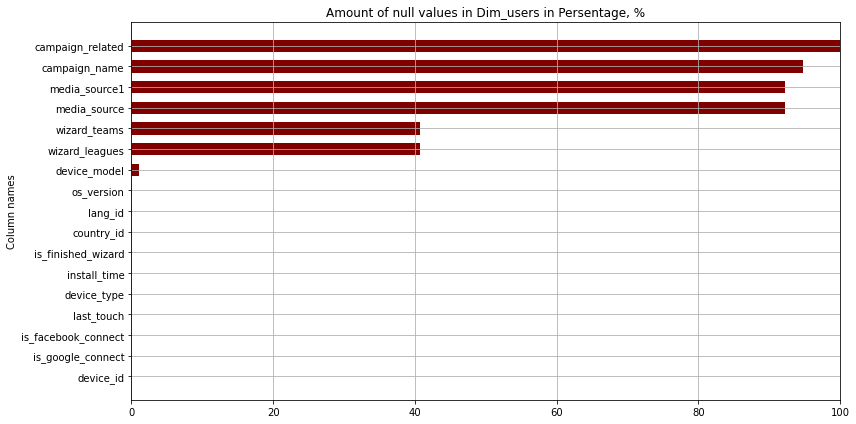

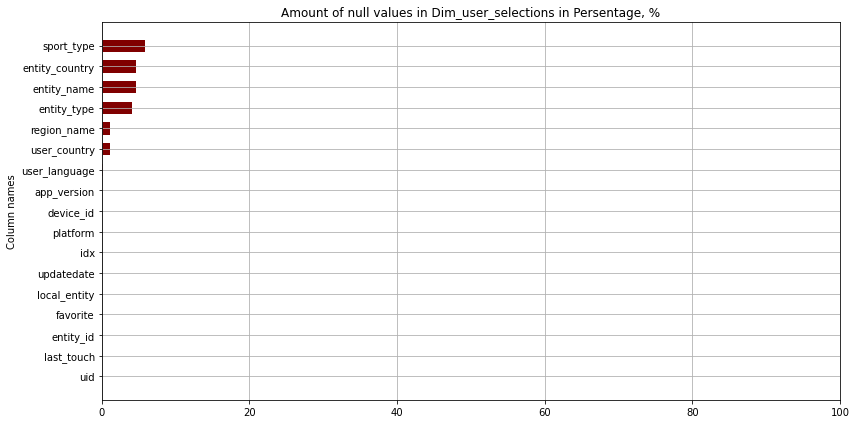

In [15]:
for source, var_name in zip([data, data_additional], ["Dim_users", "Dim_user_selections"]):
    vals = (source.isnull().sum() / source.shape[0] * 100).sort_values()
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.barh(vals.index, vals.values, height = 0.6,
    color ='maroon')
    
    ax.set_title(f"Amount of null values in {var_name} in Persentage, %")
    ax.set_ylabel("Column names")
    ax.grid()
    ax.set_xlim(0, 100)

    fig.tight_layout()

## Let's check how staitforward are all charectiristics

In [16]:
for feature in cols_for_pie:
    print(f"Cardinality of {feature}:" , len(data_additional.groupby(feature).size()))

Cardinality of platform: 2
Cardinality of user_country: 196
Cardinality of user_language: 45
Cardinality of entity_name: 24948
Cardinality of entity_country: 211
Cardinality of entity_type: 4
Cardinality of sport_type: 15
Cardinality of region_name: 7
Cardinality of app_version: 486


## The data columns with amount of categories more than 15 has high cardinality, let's plot only data that has less classes

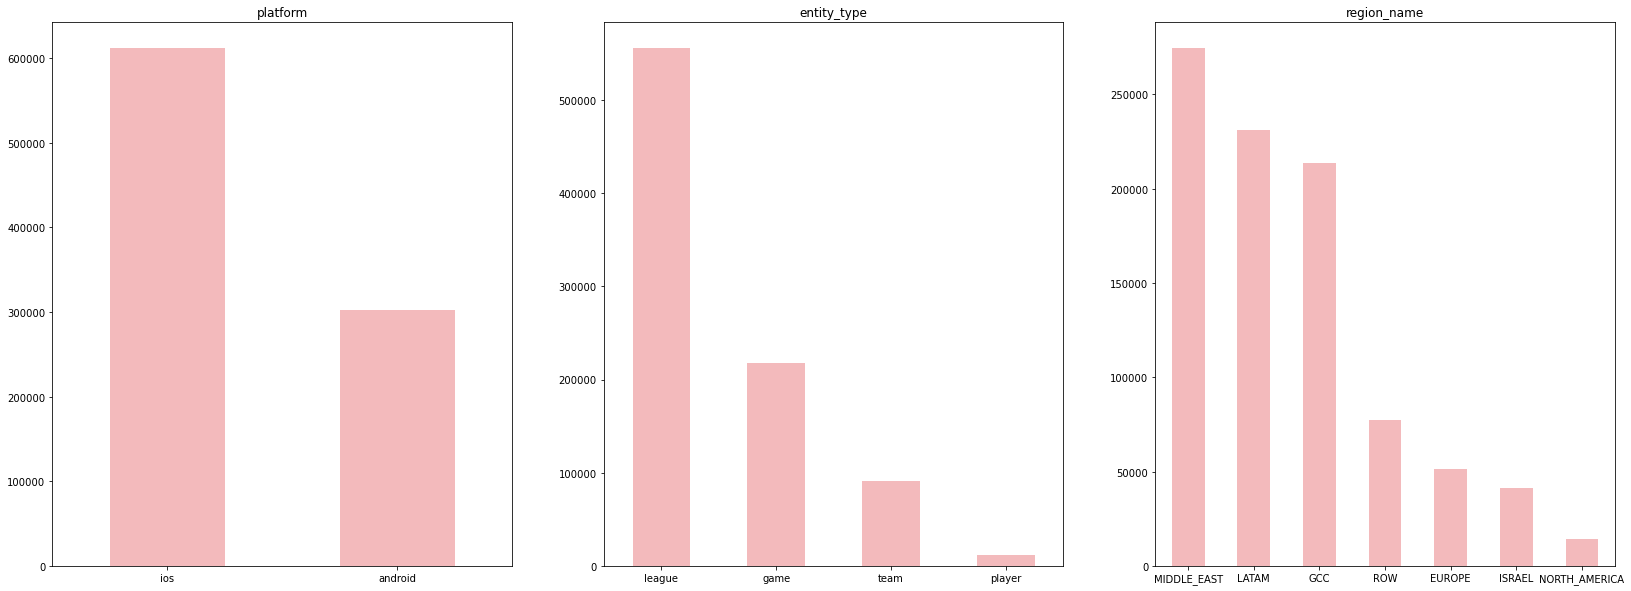

In [17]:
k = ['platform', 'entity_type', 'region_name']
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (28,10))

for i, item in enumerate(k):
    
    if i < 3:
        ax = data_additional[item].value_counts().plot(
        kind = 'bar',ax=axes[i], rot = 0, color ='#f3babc' )
        
    ax.set_title(item)

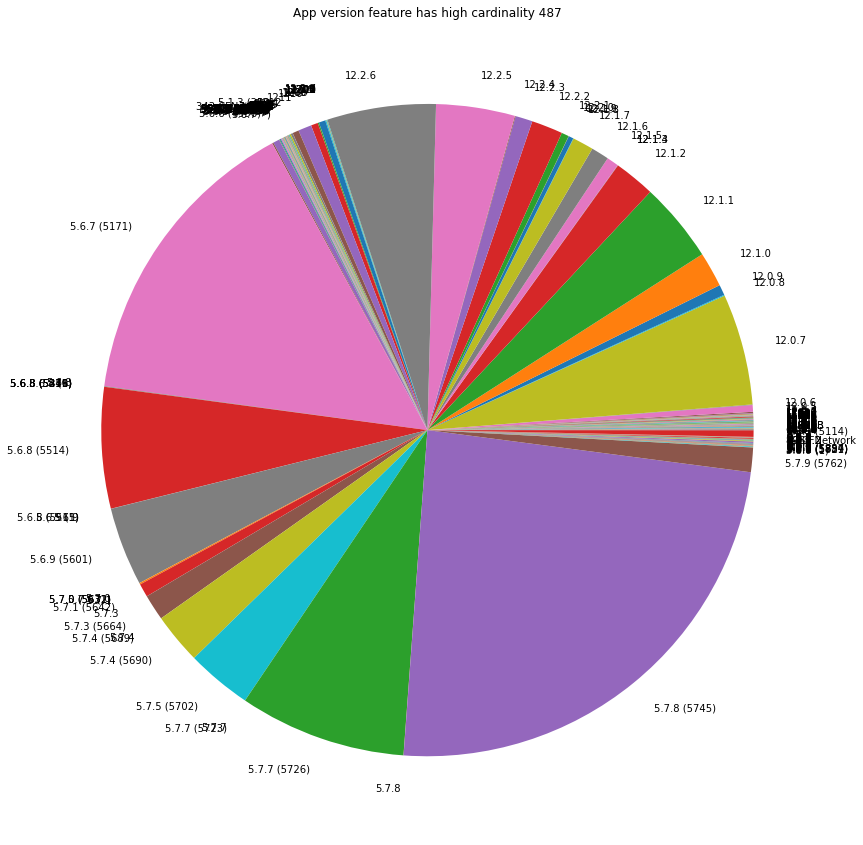

In [18]:
fig = plt.figure(figsize =(20, 15))
plt.pie(data_additional.groupby('app_version').size(), labels = data_additional.groupby('app_version').size().index)
plt.title('App version feature has high cardinality {}'.format(len(set(data_additional['app_version']))))
plt.show()

In [19]:
len(set(data_additional['app_version'].apply(lambda x: x.split('.')[0])))

84

- `It can be reduced to 84, but we should consider the logic beyong this version assigning`

In [20]:
data_additional.columns

Index(['uid', 'device_id', 'platform', 'user_country', 'user_language',
       'entity_name', 'entity_country', 'entity_type', 'sport_type',
       'local_entity', 'favorite', 'region_name', 'entity_id', 'app_version',
       'last_touch', 'updatedate', 'idx'],
      dtype='object')

## Let's aggregate features that can be useful for churn prediction for every user

- I selected the following: 'user_country', 'user_language', 'favorite', 'region_name', 'entity_id', 'app_version'
- But the data with user action is not full for all users we have

In [21]:
common_id = set(data_additional['device_id']) & set(data['device_id'])

In [22]:
print(f"""Proportion of users, for which we can append more details from activity table : \
{len(set(data.loc[data['device_id'].isin(common_id), 'device_id'])) / len(set(data['device_id']))}""")

Proportion of users, for which we can append more details from activity table : 0.41275858353684813


In [23]:
data_additional_agg = pd.DataFrame(index = data_additional.groupby('device_id')['device_id'].\
                                   agg(lambda x: x.head(1)))

In [24]:
for i in ['user_country', 'user_language', 'favorite', 'region_name', 'entity_id', 'app_version']:
    
    data_additional_agg[i] = data_additional.groupby('device_id')[i].\
                    agg(lambda x: x.value_counts().index[0])

In [25]:
data_additional_agg = data_additional_agg.reset_index()

In [26]:
data = data.merge(data_additional_agg, how = 'left', on = 'device_id')

## Dealing with nulls 

In [28]:
data.columns[((data.isnull().sum() / data.shape[0] * 100 ) > 40)]

Index(['wizard_teams', 'wizard_leagues', 'media_source', 'media_source1',
       'campaign_name', 'campaign_related', 'user_country', 'user_language',
       'favorite', 'region_name', 'entity_id', 'app_version'],
      dtype='object')

In [29]:
def plot_corr(data):
    data_corr = data.corr('spearman')
    mask = np.zeros_like(data_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    data_corr[mask] = np.nan
    return (data_corr.style.\
            background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).\
            highlight_null(null_color='#f1f1f1'))

In [30]:
data.columns

Index(['device_id', 'wizard_teams', 'wizard_leagues', 'install_time',
       'last_touch', 'lang_id', 'country_id', 'media_source', 'device_type',
       'os_version', 'media_source1', 'campaign_name', 'is_finished_wizard',
       'device_model', 'is_google_connect', 'is_facebook_connect',
       'campaign_related', 'user_country', 'user_language', 'favorite',
       'region_name', 'entity_id', 'app_version'],
      dtype='object')

In [31]:
plot_corr(data)

,wizard_teams,wizard_leagues,lang_id,country_id,is_google_connect,is_facebook_connect,campaign_related,favorite,entity_id
wizard_teams,nan,nan,nan,nan,nan,nan,nan,nan,nan
wizard_leagues,0.827817,nan,nan,nan,nan,nan,nan,nan,nan
lang_id,-0.145018,-0.091003,nan,nan,nan,nan,nan,nan,nan
country_id,0.165304,0.149556,0.383229,nan,nan,nan,nan,nan,nan
is_google_connect,0.171801,0.177572,0.278424,0.154123,nan,nan,nan,nan,nan
is_facebook_connect,0.051940,0.042786,0.121614,0.157275,0.054627,nan,nan,nan,nan
campaign_related,nan,nan,nan,nan,nan,nan,nan,nan,nan
favorite,0.022466,-0.061688,-0.028544,0.031198,-0.015043,-0.010436,nan,nan,nan
entity_id,-0.115430,-0.114202,0.072041,-0.065517,0.029544,0.025669,nan,-0.043358,nan


## Check for duplicates

In [32]:
print('no of duplicates in Dim_users: ',len(data[data.duplicated()]))
data.drop_duplicates(inplace=True)

no of duplicates in Dim_users:  0


In [33]:
print('no of duplicates in Dim_user_selections: ',len(data_additional[data_additional.duplicated()]))
data_additional.drop_duplicates(inplace=True)

no of duplicates in Dim_user_selections:  0


## Let's create target column, that will be used in analysis 
- `Hopefuly we don't have nulls in last_touch and install_time cols'

In [34]:
data[['last_touch', 'install_time']] = data[['last_touch', 'install_time']].\
                                    apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f'))

In [35]:
data['retention'] = (data['last_touch'] - data['install_time']).dt.days

In [36]:
data['churn'] = None
data.loc[data['retention'] >= 5, 'churn'] = 0
data.loc[data['retention'] < 5, 'churn'] = 1

## Let's check does the retension of users with ios/Android devices differs 

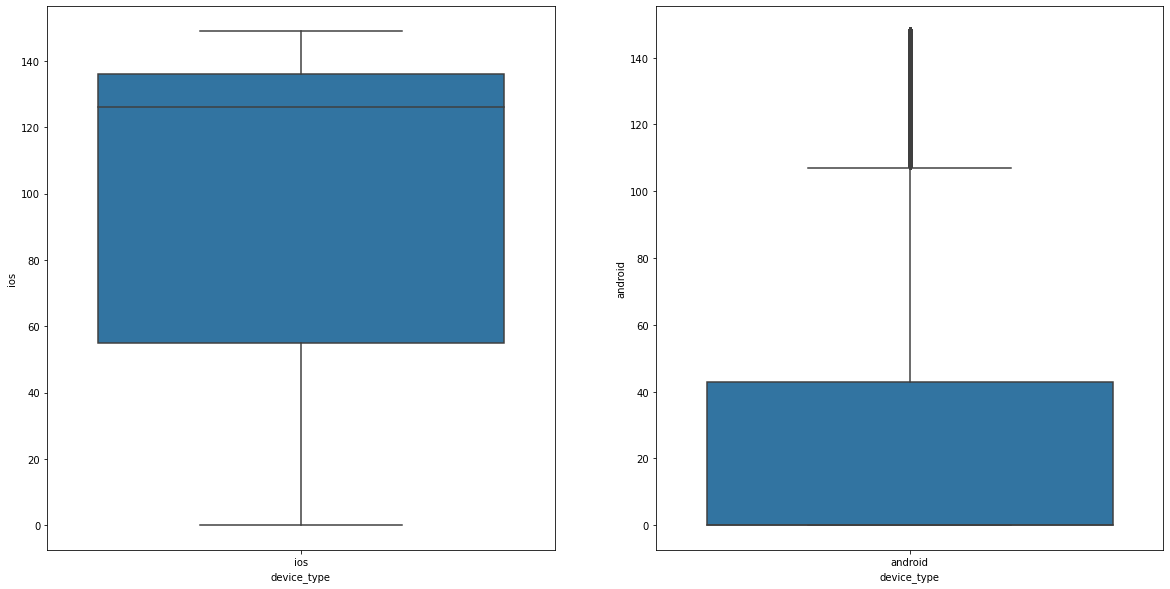

In [37]:
selection = set(data['device_type'])
fig, axes = plt.subplots(1, len(selection), figsize = (20, 10))
for i, col in enumerate(selection):
    mask = data['device_type'] == col
    ax = sns.boxplot(x="device_type", y="retention", data=data[mask], ax=axes.flatten()[i])
    ax.set_ylabel(col)
plt.show()

## Check whether there is an error in date updates

In [38]:
print(f"""Checking for negative retention days: \
 {len(data.loc[(data['last_touch'] - data['install_time']) < pd.Timedelta(0, 'days'), :])} days """)

Checking for negative retention days:  0 days 


## DATA PREPROCESSING
- ` Let's drop unnessesary columns`
- `Aggregate features from users actions - Dim_user_selections `
` 
- `And check the balance in data regarding the target retention`
- `Apply sampling techniques if needed`

In [54]:
def check_types(data):
    cols = ['wizard_teams', 'wizard_leagues', 'lang_id', 'country_id', \
    'media_source' , 'device_type', 'os_version', 'media_source1', 'campaign_name', 'is_finished_wizard', \
    'device_model', 'is_google_connect', 'is_facebook_connect', 'retention', \
            'user_country', 'user_language', 'favorite', 'region_name', 'entity_id',\
            'app_version', 'churn']
    for i in cols:
        if data[i].dtype == 'object':
            data[i] = data[i].astype('category').cat.codes
    return data[cols]

In [56]:
data_corr = check_types(data)
plot_corr(data_corr)

,wizard_teams,wizard_leagues,lang_id,country_id,media_source,device_type,os_version,media_source1,campaign_name,is_finished_wizard,device_model,is_google_connect,is_facebook_connect,retention,user_country,user_language,favorite,region_name,entity_id,app_version,churn,random
wizard_teams,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
wizard_leagues,0.827817,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lang_id,-0.145018,-0.091003,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
country_id,0.165304,0.149556,0.383229,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
media_source,-0.089565,-0.085491,0.314479,0.000090,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
device_type,0.088269,0.068652,0.411528,0.394637,-0.111840,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
os_version,0.016738,0.003311,0.249684,0.243280,-0.062278,0.543019,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
media_source1,-0.089565,-0.085491,0.314479,0.000090,1.000000,-0.111840,-0.062278,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
campaign_name,-0.187382,-0.176955,0.331232,-0.077804,0.782778,-0.184653,-0.106052,0.782778,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
is_finished_wizard,0.083245,0.081463,0.744349,0.552913,0.197426,0.607109,0.366787,0.197426,0.153899,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


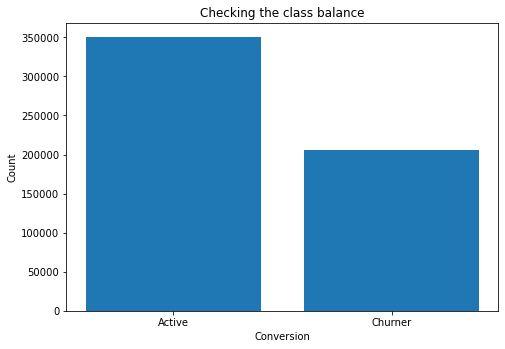

In [57]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Active', 'Churner'],[data.query('churn == 0').shape[0], data.query('churn == 1').shape[0]])
plt.title('Checking the class balance')
plt.xlabel("Conversion")
plt.ylabel("Count")
plt.show()

## Also all additional data from action table we have only if the user was active

### Let's train a Benchmark model on our data.  I propose to use  Random Forest model. After training we can compute  how much each feature contributes to decreasing the impurity.

***Let's add one non-standard thing in preparing the data. I propose to add  a random column to the dataset. It has no predictive power over the dependent variable, so it should not be an important feature in methods that will be used for finding the most promising features.***

In [63]:
data_corr['random'] = np.random.random(size = len(data_corr)).astype('float')


In [74]:
def baseline_with_metrics(df, n):
    SEED = 42
    mean_auc = 0.
    oob_score = 0.
    test_accuracy = 0.
    for i in range(n):
        clf = RandomForestClassifier(n_estimators = 100,
                                     n_jobs = -1,
                                     oob_score = True,
                                     bootstrap = True,
                                     class_weight = 'balanced', random_state = 42)

        X, y = df.drop(columns = ['churn', 'retention']), df['churn']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = i*SEED)
        clf.fit(X_train, y_train)

        preds = clf.predict(X_test)
        print(f'{i} split training')
        print(f'precision on test {metrics.precision_score(y_test, preds)}')
        print(f'recall on test {metrics.recall_score(y_test, preds)}')
        print('-------------')
        
        mean_auc += metrics.roc_auc_score(y_test, preds)
        oob_score += clf.oob_score_
        test_accuracy += clf.score(X_test, y_test)


        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

        forest_importances = pd.Series(importances, index=X.columns)
        forest_importances = forest_importances.sort_values(ascending = False)
        fig, ax = plt.subplots(figsize = (10, 4))
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title("Feature importances")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()


    print(f"Mean test roc_auc {round(mean_auc/n, 3)}")
    print(f"Mean out-of-bag accuracy {round(oob_score/n, 3)}")
    print(f"Mean accuracy in test {round(test_accuracy/n, 3)}")
    return forest_importances
    

In [72]:
data_corr.fillna(0)
# [data_corr.notnull().all(axis = 1)]

,wizard_teams,wizard_leagues,lang_id,country_id,media_source,device_type,os_version,media_source1,campaign_name,is_finished_wizard,...,is_facebook_connect,retention,user_country,user_language,favorite,region_name,entity_id,app_version,churn,random
0,10.0,1.0,27.0,122.0,-1,1,105,-1,-1,1,...,False,143,150,0,1.0,1,573.0,341,0,0.027574
1,1.0,4.0,1.0,114.0,-1,1,105,-1,-1,1,...,True,148,83,9,0.0,4,13.0,343,0,0.373662
2,52.0,20.0,27.0,122.0,-1,1,107,-1,-1,1,...,True,147,150,0,0.0,1,167.0,344,0,0.466422
3,0.0,0.0,27.0,131.0,-1,1,95,-1,-1,1,...,True,146,51,0,0.0,4,332.0,338,0,0.464402
4,1.0,1.0,31.0,21.0,-1,1,105,-1,-1,1,...,False,144,25,30,1.0,3,1225.0,343,0,0.845511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556875,0.0,0.0,-1.0,21.0,-1,0,0,-1,-1,0,...,False,0,-1,-1,0.0,-1,0.0,-1,1,0.369157
556876,0.0,0.0,27.0,131.0,-1,0,129,-1,-1,0,...,False,0,51,0,0.0,4,5595.0,167,1,0.347265
556877,0.0,0.0,-1.0,0.0,-1,0,9,-1,-1,0,...,False,0,-1,-1,0.0,-1,0.0,-1,1,0.301618
556878,0.0,0.0,-1.0,0.0,-1,0,18,-1,-1,0,...,False,0,-1,-1,0.0,-1,0.0,-1,1,0.731807


0 split training
precision on test 0.9871856517766986
recall on test 0.9950563431479462
-------------
1 split training
precision on test 0.9871110469869667
recall on test 0.9958274707680365
-------------
2 split training
precision on test 0.9868976874060285
recall on test 0.994995187680462
-------------
Mean test roc_auc 0.994
Mean out-of-bag accuracy 0.993
Mean accuracy in test 0.993


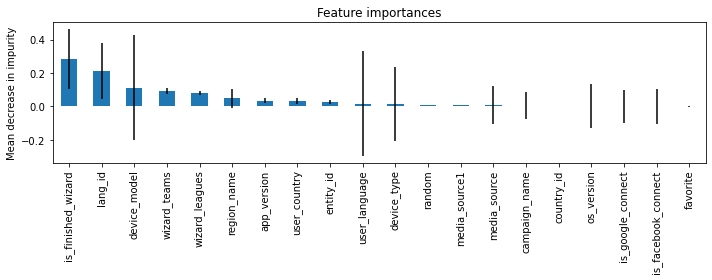

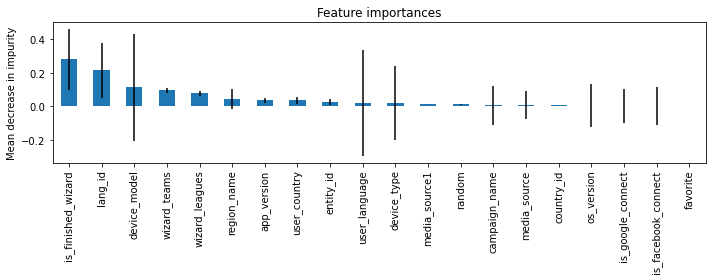

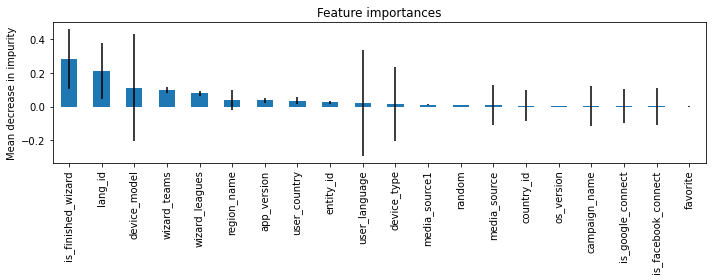

In [75]:
# df = data_corr[data_corr.notnull().all(axis = 1)]
forest_importances = baseline_with_metrics(data_corr.fillna(0), 3)

- `The activity table mostly contains the data about users who are active with good retention`

In [82]:
# The activity table 
data_corr[data_corr[['user_country', 'user_language', \
                    'favorite', 'region_name', 'entity_id', 'app_version']].\
                      notnull().all(axis = 1)]['churn'].value_counts()

0    227105
1      2752
Name: churn, dtype: int64

In [84]:
data_corr[data_corr.notnull().all(axis = 1)]['churn'].value_counts()

0    219329
Name: churn, dtype: int64

### Let's do the prediction with only features that are available for all types of users (active and unactive) 

0 split training
precision on test 0.9869227625664079
recall on test 0.9949109414758269
-------------
1 split training
precision on test 0.9867785283300079
recall on test 0.9958032118771529
-------------
2 split training
precision on test 0.9865896726162069
recall on test 0.9948508180943214
-------------
Mean test roc_auc 0.994
Mean out-of-bag accuracy 0.993
Mean accuracy in test 0.993


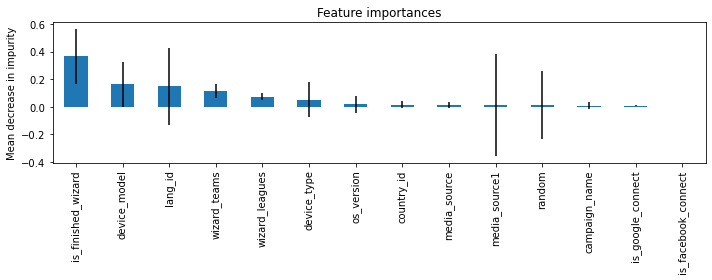

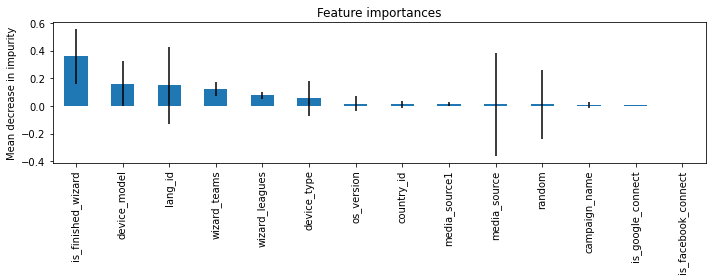

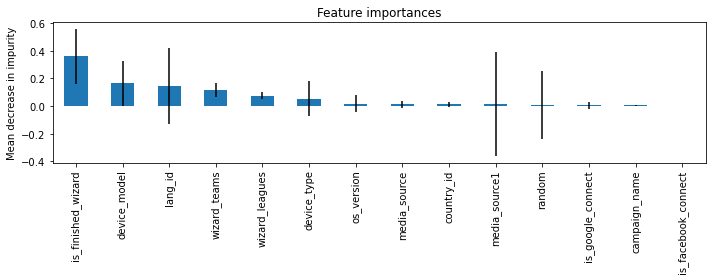

In [90]:
cols = ['user_country', 'user_language', \
                    'favorite', 'region_name', 'entity_id', 'app_version']
df = data_corr.loc[:, ~data_corr.columns.isin(cols)].fillna(0).copy()
forest_importances = baseline_with_metrics(df, 3)

## And also I will propose to exclude all features with importance less then random feature has

In [112]:
val = forest_importances[forest_importances.index == 'random'].values[0]
new_features = forest_importances[forest_importances.values > val].index

0 split training
precision on test 0.986673058485139
recall on test 0.997552405185993
-------------
1 split training
precision on test 0.9866810655147589
recall on test 0.9974042986754645
-------------
2 split training
precision on test 0.9863127826707927
recall on test 0.9969923002887392
-------------
Mean test roc_auc 0.995
Mean out-of-bag accuracy 0.994
Mean accuracy in test 0.994


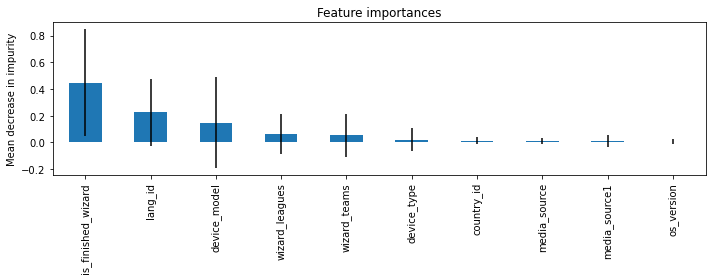

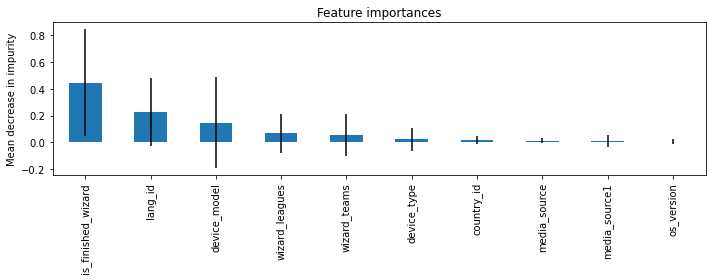

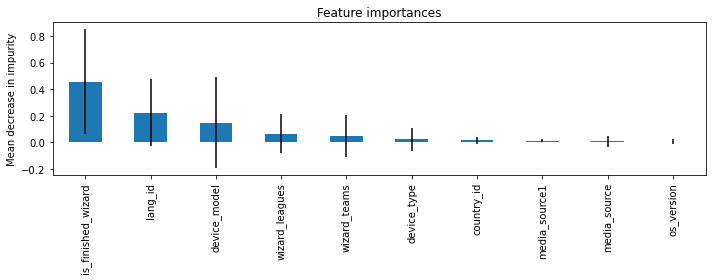

In [121]:
df = data_corr.loc[:, new_features.tolist() + ['churn', 'retention']].fillna(0).copy()
new_forest_importances = baseline_with_metrics(df, 3)

- `The main assumptions we should consider that our baseling is RF clf, so we should assume that it's a biased approach and it has a tendency to inflate the importance of continuous features or high-cardinality categorical variables`
- `Also we have a little unbalanced dataset and some sampling techniques could be applied but we have cery good metrics on test set, so I decided not to apply them. In case of using it, we should aim to use generalised. Need to do undersampling step multiple times and obtain many different undersampled datasets to train our model on to avoid bias `